# Kelmarsh Open Data

In [127]:
import os
import pandas as pd
import re

base_dir = "/Users/jihakim/Library/CloudStorage/OneDrive-UTCloud/Downloads/KelmarshFarm"
desired_years = [2020]  
all_merged = []

for foldername in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, foldername)
    # Check if the folder contains "SCADA" and any of the desired years
    if os.path.isdir(folder_path) and "SCADA" in foldername and any(str(year) in foldername for year in desired_years):
        year_match = re.search(r"(\d{4})", foldername)
        year = year_match.group(1) if year_match else "Unknown"

        for filename in os.listdir(folder_path):
            # Check if the file contains "Turbine_Data" and any of the desired years
            if filename.endswith(".csv") and "Turbine_Data" in filename and any(str(year) in filename for year in desired_years):
                data_path = os.path.join(folder_path, filename)
                turbine_match = re.search(r"Kelmarsh_(\d+)", filename)
                turbine = turbine_match.group(1) if turbine_match else "Unknown"

                status_filename = filename.replace("Turbine_Data", "Status")
                status_path = os.path.join(folder_path, status_filename)

                try:
                    df_data = pd.read_csv(data_path, header=9)
                    df_data["Timestamp"] = pd.to_datetime(df_data["# Date and time"], errors="coerce")
                    df_data["turbine"] = turbine
                    df_data["year"] = year
                except Exception as e:
                    print(f" Error : {data_path} → {e}")
                    continue

                try:
                    with open(status_path, "r") as f:
                        lines = f.readlines()
                    skip = next(i for i, l in enumerate(lines) if not l.startswith("#") and "," in l)
                    df_status = pd.read_csv(status_path, skiprows=skip)
                    df_status["Timestamp start"] = pd.to_datetime(df_status["Timestamp start"], errors="coerce")
                    df_status["Timestamp end"] = pd.to_datetime(df_status["Timestamp end"], errors="coerce")
                except Exception as e:
                    print(f" Error {status_path} → {e}")
                    continue

                for _, row in df_status.iterrows():
                    if pd.notnull(row["Timestamp start"]) and pd.notnull(row["Timestamp end"]):
                        mask = (df_data["Timestamp"] >= row["Timestamp start"]) & (df_data["Timestamp"] <= row["Timestamp end"])
                        df_data.loc[mask, "Status"] = row["Status"]
                        df_data.loc[mask, "Code"] = row["Code"]
                        df_data.loc[mask, "IEC category"] = row["IEC category"]
                all_merged.append(df_data)


final_df = pd.concat(all_merged, ignore_index=True)
final_df.to_csv(f"kelmarsh_{desired_years}_with_status.csv", index=False)
print(f"kelmarsh_{desired_years}_with_status.csv saved")

✅  kelmarsh_filtered_years_with_status.csv 


In [5]:

abnormal_status = ['Out of Environmental Specification', 'Technical Standby', 'Out of Electrical Specification',
'Scheduled Maintenance', 'Forced outage','Requested Shutdown']

df["Target"] = df["IEC category"].apply(lambda x: 1 if x in abnormal_status else 0)


df.sort_values(by=['turbine', 'Timestamp']).reset_index(drop=True)






,# Date and time,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",...,"Drive train acceleration, StdDev (mm/ss)","Tower Acceleration X, StdDev (mm/ss)","Tower Acceleration Y, StdDev (mm/ss)",Timestamp,turbine,year,Status,Code,IEC category,Target
0,2020-01-01 00:00:00,3.887291,0.646663,2.629255,5.138163,7.1,4.390778,0.595037,2.894442,5.923776,...,NaN,NaN,NaN,2020-01-01 00:00:00,1,2020,NaN,NaN,NaN,0
1,2020-01-01 00:10:00,3.848941,0.787454,2.456995,5.551735,7.1,4.216298,0.686900,3.387660,5.713417,...,NaN,NaN,NaN,2020-01-01 00:10:00,1,2020,NaN,NaN,NaN,0
2,2020-01-01 00:20:00,4.043625,0.983279,2.726894,6.251913,7.1,4.323125,1.053373,3.305274,6.688592,...,NaN,NaN,NaN,2020-01-01 00:20:00,1,2020,NaN,NaN,NaN,0
3,2020-01-01 00:30:00,3.330342,0.689929,1.541864,4.689322,7.1,3.584192,0.524914,2.547872,4.671783,...,NaN,NaN,NaN,2020-01-01 00:30:00,1,2020,NaN,NaN,NaN,0
4,2020-01-01 00:40:00,3.388536,0.897104,1.832924,5.210185,7.1,3.668500,0.885085,1.908008,5.278419,...,NaN,NaN,NaN,2020-01-01 00:40:00,1,2020,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316219,2020-12-31 23:10:00,3.397390,0.714660,2.083147,4.594281,7.0,3.656650,0.777789,2.365524,5.043893,...,0.0,24.185632,12.490830,2020-12-31 23:10:00,6,2020,Warning,7057.0,NaN,0
316220,2020-12-31 23:20:00,3.024878,0.681220,2.062728,4.161775,7.0,3.102206,0.716219,2.021975,4.596538,...,0.0,46.463180,13.128132,2020-12-31 23:20:00,6,2020,Warning,7057.0,NaN,0
316221,2020-12-31 23:30:00,3.834370,0.687778,2.755109,4.960705,7.0,3.986771,0.471164,2.756309,4.725334,...,0.0,43.390573,10.584705,2020-12-31 23:30:00,6,2020,Warning,7057.0,NaN,0
316222,2020-12-31 23:40:00,4.211745,0.475226,3.123760,5.282207,7.0,4.235343,0.397805,3.239091,4.994462,...,0.0,39.212187,10.562059,2020-12-31 23:40:00,6,2020,Warning,7057.0,NaN,0


In [7]:
# df = final_df.copy()
datetime_columns = ['# Date and time'] # , 'Timestamp']
target_columns = ['Status','Code', 'IEC category']
df = df.drop(target_columns, axis=1)
df = df.drop(datetime_columns, axis=1)

# XGBOOST

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["month"] = df["Timestamp"].dt.month
X = df.drop(["Timestamp", "Target"], axis=1)
y = df["Target"]

# 3. Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. XGBoost Training 
model = XGBClassifier(n_estimators=20, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc = roc_auc_score(y_val, y_proba)
cm = confusion_matrix(y_val, y_pred)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ ROC-AUC: {roc:.4f}")
print(f"✅ Confusion Matrix:\n{cm}")



/opt/miniconda3/envs/ts/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:14:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.9964
✅ F1-Score: 0.7760
✅ ROC-AUC: 0.9983
✅ Confusion Matrix:
[[62622    29]
 [  199   395]]


### Why Feature Importances Differ: SHAP vs XGBoost `feature_importances_`

---
■ Summary of Key Points
model.feature_importances_ reflects how often and how early features are split on in the trees.
SHAP considers actual contribution to each prediction, across all samples.
SHAP is more robust for interpretability, especially in correlated or complex feature spaces.


📊 Feature Importances:
Production-based Contractual Avail.                       0.369081
Blade angle (pitch position) A, Max (°)                   0.294279
Generator RPM (RPM)                                       0.108821
Motor current axis 3, Max (A)                             0.020088
Blade angle (pitch position) A, Standard deviation (°)    0.018013
Rotor speed (RPM)                                         0.016384
Wind speed Sensor 1, Minimum (m/s)                        0.014908
Turbine Power setpoint (kW)                               0.013143
Gear oil inlet pressure, Min (bar)                        0.012788
Time-based IEC B.2.2 (Users View)                         0.012599
dtype: float32


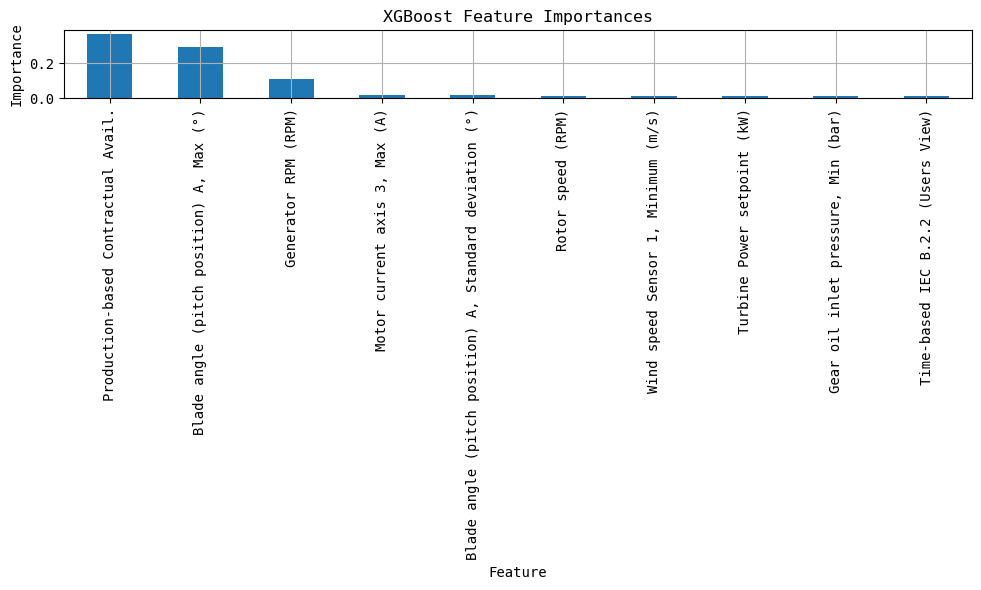

In [42]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans Mono'  # or 'Courier New', 'Consolas' 등


importances = model.feature_importances_
feature_names = X_train.columns
importances_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
print("📊 Feature Importances:")
print(importances_series)

plt.figure(figsize=(10, 6))
importances_series.plot(kind="bar")
plt.title("XGBoost Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


### SHAP-Based Monthly Feature Importance: Interpretation

**■ Key Observations**

- **Stable Importance Rankings**  
  - `Blade angle (pitch position) A (°)` consistently holds the highest importance across all months.
  - `Turbine Power Setpoint (kW)` and `Time-based IEC B.2.2` also show steady influence, indicating their robustness in different seasonal conditions.

- **Low Volatility in Feature Influence**  
  - At least top 3 features exhibit **relatively stable SHAP values** over time.
  - This consistency suggests the model has **reliable signal detection** and is not overly sensitive to short-term fluctuations.

- **Seasonal Spikes**  
  - `Blade angle (pitch position) A, Max (°)` shows a notable spike in December, possibly linked to winter operational patterns or control changes under extreme conditions.
  - Some upticks in other features (e.g., `Contractual Availability`, `Rear bearing temp`) during specific months may indicate seasonal maintenance cycles or environmental effects.


**■ Interpretation Summary**

- Temporal feature importance **does not vary drastically**, which enhances model robustness for real-time and predictive use.
- Dominant features like blade angle and power setpoint maintain their influence year-round, reinforcing their utility in fault detection logic.
- Anomalous changes in specific months (e.g., December) may warrant further domain-specific investigation.




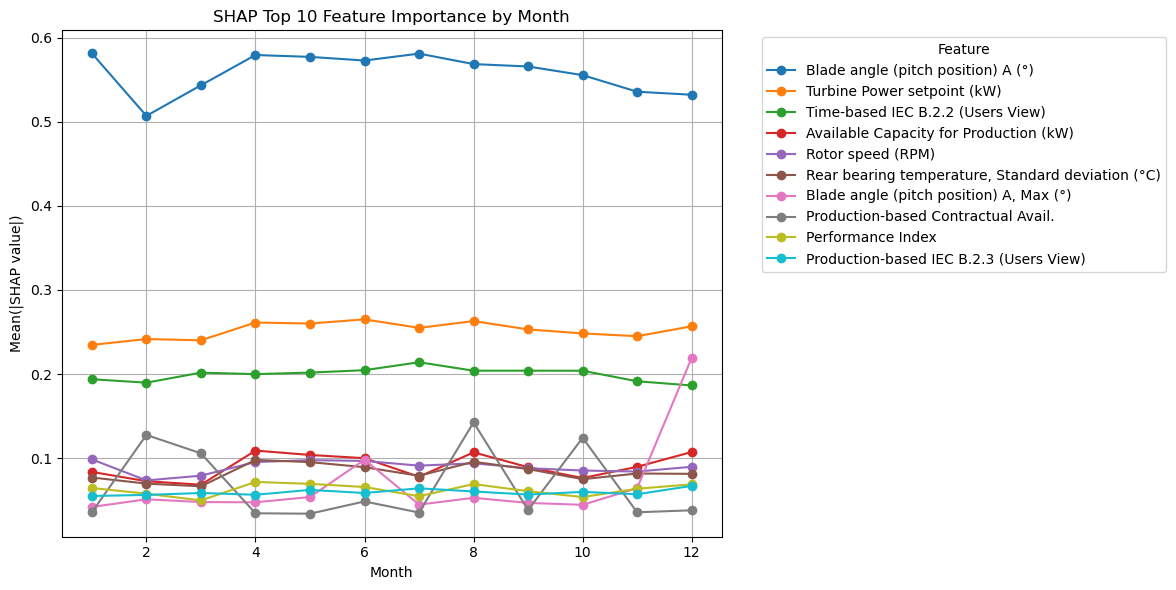

In [25]:
import shap
import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(model)


monthly_importance = {}


for m in sorted(df["month"].unique()):
    X_month = X_val[df.loc[X_val.index, "month"] == m]
    if X_month.empty:
        continue

    shap_vals = explainer.shap_values(X_month)
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)  
    monthly_importance[m] = dict(zip(X_month.columns, mean_abs_shap))


importance_df = pd.DataFrame(monthly_importance).T.fillna(0)


top_features = importance_df.mean().sort_values(ascending=False).head(10).index
importance_top10 = importance_df[top_features]


plt.figure(figsize=(12, 6))
for col in top_features:
    plt.plot(importance_top10.index, importance_top10[col], marker='o', label=col)

plt.title("SHAP Top 10 Feature Importance by Month")
plt.xlabel("Month")
plt.ylabel("Mean(|SHAP value|)")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
blade_col = "Blade angle (pitch position) A (°)"
normal_mean = df[df["Target"] == 0][blade_col].mean()
abnormal_mean = df[df["Target"] == 1][blade_col].mean()

print(f"Normal Mean: {normal_mean:.2f}°")
print(f"Abnormal Mean: {abnormal_mean:.2f}°")


Normal Mean: 5.88°
Abnormal Mean: 78.37°


### SHAP Interaction Analysis: `Blade angle (pitch position) A (°)` × `Turbine Power Setpoint (kW)`

---

**■ Key Interpretation Summary**
- There are two clusters of SHAP values

- When `Blade angle (A)` is **low** and `Power Setpoint` is **high**:  
  → SHAP value is **negative** → Model interprets as **normal state**

- When `Blade angle (A)` is **high** and `Power Setpoint` is **low**:  
  → SHAP value is **positive** → Model interprets as **abnormal state**

- The interaction between `Blade angle` and `Power Setpoint` is critical for predicting turbine operating mode.

---

**■ Quantitative Summary (Based on SHAP)**

| Blade angle (°) range | Power Setpoint (kW) | SHAP Value Impact | Model Interpretation |
|------------------------|----------------------|--------------------|------------------------|
| 0 ~ 20                 | High (red tones)     | Negative           | Normal                 |
| 20 ~ 40                | Medium               | Mixed              | Transition zone        |
| > 40                   | Low (blue tones)     | Positive           | Abnormal               |

---


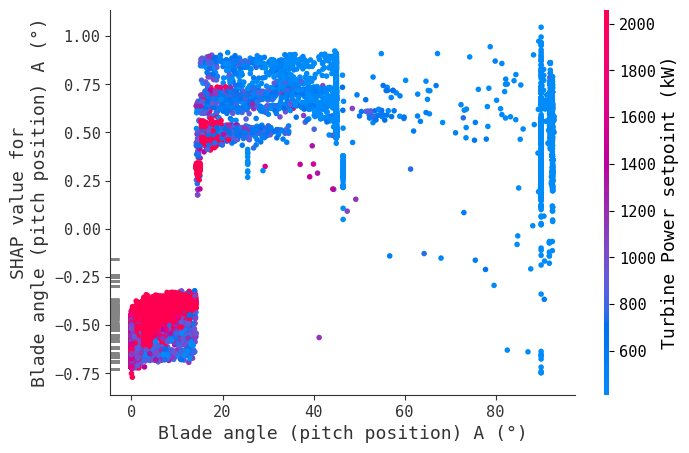

In [ ]:

shap.dependence_plot(
    ind=main_feat,
    shap_values=shap_values,
    features=X_val,
    interaction_index=interact_feat
)

# plt.title(f"SHAP Interaction: {main_feat} × {interact_feat}", fontsize=14)
# plt.xlabel(main_feat)
# plt.ylabel("SHAP value")



### Further Exploration Directions

---

**■ Temporal Forecasting (Real-time vs Predictive)**

- Current SHAP-based analysis is **real-time**, relying only on the current timestamp's data.
- To enhance operational utility, investigate a **predictive model** that allows:
  - Forecasting abnormal states **3 hours in advance**
  - Generating early warnings for fault-prone conditions
- Proposed method:
  - Create lag features (e.g., 1h, 2h, 3h delay)
  - Apply time-shifted labeling to simulate future-state classification
  - Evaluate if early SHAP patterns are preserved in advance states

---

**■ Cross-Year Generalization**

- Extend analysis to **additional years** of SCADA data (e.g., 2017–2021)
- Purpose:
  - Validate consistency of SHAP-based feature importance
  - Detect seasonal or structural changes in feature behavior
- Suggest comparing:
  - Monthly SHAP trends across years
  - Stability of rules such as blade angle × power setpoint combinations

---

**■ Model Architecture Expansion (Beyond XGBoost)**

- Integrate deep learning-based models that **explicitly handle temporal dependencies**
- Suggested model: `Temporal Fusion Transformer (TFT)`
  - Designed for multivariate time series forecasting
  - Provides **interpretable attention-based insights** per time step and feature
- Compare interpretability:
  - SHAP (XGBoost) vs Attention Weights (TFT)
- Evaluate model quality not only by AUC/F1, but also **temporal reasoning quality**

---

**■ Summary of Next Steps**

| Direction                          | Goal                                      |
|-----------------------------------|-------------------------------------------|
| Early prediction (3h ahead)       | Enable preemptive alerts                  |
| Multi-year data comparison        | Generalize feature importance patterns    |
| TFT model integration             | Capture temporal dynamics + explainability|
| Interpretability comparison       | SHAP vs Attention                         |
